In [ ]:
import glob

from potoo.plot import *
from potoo.util import *
import sklearn

from cache import *
from constants import *
from datasets import *
from features import *
from load import *
from sp14.model import *
from util import *
from viz import *

figsize('inline_short');

In [ ]:
recs_paths = load_recs_paths([
    'peterson-field-guide',
    'recordings',
])
display(
    df_summary(recs_paths),
    recs_paths[:5],
)

In [ ]:
recs = load_recs_data(recs_paths)

In [ ]:
display(
    df_summary(recs),
    recs[:5],
)

In [ ]:
(recs
    .pipe(df_reverse_cat, 'species_longhand')
    .pipe(ggplot, aes(x='species_longhand'))
    + geom_bar()
    + coord_flip()
    + facet_grid('. ~ dataset')
    + ylab('num recordings')
    + theme_figsize(aspect_ratio=1.5/1)
    + ggtitle('How many training recordings per species?')
)

In [ ]:
# Stats
(recs
    .assign(
        n=1,
        duration_h=lambda df: df.duration_s / 3600,
        samples_gb=lambda df: df.samples_mb / 1024,
        species=lambda df: df.species.cat.remove_unused_categories(),  # Else groupby includes all categories
    )
    .groupby([
        'dataset',
        'species',
    ])
    [['n', 'duration_h', 'samples_gb', 'samples_n']]
    .sum()
    .dropna()
)

In [ ]:
display(
    df_summary(recs),
    recs[:10],
    (recs
        .assign(n=1)
        .groupby(['dataset', 'species'])
        ['n'].sum()
    ),
)

In [ ]:
%%time
# Basic features
from sp14.model import *
features = Features()
recs['spectro'] = features.spectros(recs)
recs['patches'] = features.patches(recs)

In [ ]:
with with_figsize(width=25/2, height=212/2):
    plot_many_spectros(t_max=30, recs=(recs
        [lambda df: df.dataset == 'peterson-field-guide']
        [-50:]  # Avoid heavy plot
    ))

In [ ]:
%%time
# Fit projection, add learned features
from sp14.model import *

k, n = 50,  60   # Faster dev
# k, n = 500, 300  # Mem safe (~17m uncached for 6 configs)
# k, n = 500, 535  # Full [XXX Not mem safe] [len(peterson) is currently 535]
recs_train_projection = (recs
    [lambda df: df.dataset == 'peterson-field-guide']
    .pipe(sklearn.utils.shuffle, random_state=0)
    .sample(n, random_state=0)
)

projection = Projection(k=k)
projection.fit(recs_train_projection)
recs['feat'] = projection.transform(recs)

In [ ]:
# Fit search
from sp14.model import *

recs_eval = (recs
    [lambda df: df.dataset == 'peterson-field-guide']
    # [:10]  # Faster dev
    .reset_index(drop=True)
)
train_n, test_n = (len(recs_eval)+1)//2, len(recs_eval)//2
recs_train, recs_test = (recs_eval
    .pipe(sklearn.utils.shuffle, random_state=0)
    .sample(train_n + test_n, random_state=0)
    .pipe(lambda df: (
        df[:train_n],
        df[train_n : train_n + test_n],
    ))
)
log('params', **{
    'recs_eval': len(recs_eval),
    'recs_train': len(recs_train),
    'recs_test': len(recs_test),
})

search = Search()
search.fit(recs_train)

[01:06:55.828] params
  recs_eval: 535
  recs_train: 268
  recs_test: 267
[01:06:55.886] Search.fit:feats
  recs: 268
  (n, f*p): [268, 150]
[Memory]10654.3s, 177.6min: Loading _fit from /Users/danb/hack/bubo/data/cache/joblib/sp14/model/_fit/aedcaa35910fa6cb25e55adbf5ccfd8a
_________________________________________________fit cache loaded - 0.0s, 0.0min
[01:06:55.890] Search.fit:knn
  knn.get_params: {algorithm: auto, leaf_size: 30, metric: minkowski, metric_params: null, n_jobs: 1, n_neighbors: 3, p: 2, weights: uniform}
  knn.classes_: [SCQU, MONQ, WITU, OSPR, KILL, BEKI, AMCR, CORA, CACH, BCCH, BOCH, TUTI, BCTI, BUSH, RBNU, WBNU, BRCR, CACW, ROWR, CANW, CARW, BEWR, HOWR, WIWR, SEWR, MAWR, SWTH, HETH, AMRO, EUST, CEDW, OCWA, WIWA, SOSP, WCSP]
  knn.classes_.len: 35


Search(knn_config=AttrDict({'n_neighbors': 3}))

In [ ]:
search.species(recs_test[:5])

[00:11:46.871] Search.species
  recs: 5
  (n, k*a): [5, 150]
  species: 5


,species_true,species_pred
160,TUTI,SOSP
144,TUTI,TUTI
493,WIWA,BUSH
29,WITU,CORA
390,SWTH,SWTH


In [ ]:
search.species_probs(recs_test[:5]).T[:search.knn_.n_neighbors + 1].T

[00:11:47.003] Search.species_probs
  recs: 5
  (n, k*a): [5, 150]
  knn.n_neighbors: 3
  species_probs: [5, 35]


,species_true,0,1,2
160,TUTI,"[0.333, SOSP]","[0.333, TUTI]","[0.333, WCSP]"
144,TUTI,"[1.0, TUTI]","[0.0, AMCR]","[0.0, AMRO]"
493,WIWA,"[1.0, BUSH]","[0.0, AMCR]","[0.0, AMRO]"
29,WITU,"[0.333, CORA]","[0.333, EUST]","[0.333, WITU]"
390,SWTH,"[0.333, SWTH]","[0.333, TUTI]","[0.333, WCSP]"


In [ ]:
search.similar_recs(recs_test[:5], 10)

[00:11:47.629] Search.similar_recs
  recs: 5
  (n, k*a): [5, 150]
  similar_recs: [5, 10]


,species_true,0,1,2,3,4,5,6,7,8,9
160,TUTI,"[24, 13.3, WCSP]","[99, 15.7, TUTI]","[163, 16.1, SOSP]","[189, 16.8, SOSP]","[153, 16.9, TUTI]","[74, 16.9, SWTH]","[73, 17.1, BCCH]","[210, 17.4, BUSH]","[120, 17.7, OCWA]","[252, 18.1, EUST]"
144,TUTI,"[202, 9.3, TUTI]","[83, 11.7, TUTI]","[140, 11.8, TUTI]","[229, 12.6, TUTI]","[84, 13.5, OSPR]","[35, 13.6, BEWR]","[111, 13.8, CARW]","[256, 13.9, CARW]","[191, 14.0, CARW]","[16, 14.0, HETH]"
493,WIWA,"[210, 11.6, BUSH]","[23, 12.2, BUSH]","[176, 13.0, BUSH]","[163, 13.4, SOSP]","[252, 13.5, EUST]","[92, 13.8, BUSH]","[265, 14.1, HOWR]","[192, 14.2, EUST]","[264, 14.2, CACH]","[186, 14.2, BCTI]"
29,WITU,"[45, 12.8, WITU]","[253, 13.5, CORA]","[119, 16.3, EUST]","[72, 16.5, WITU]","[165, 16.7, CACW]","[215, 17.8, AMCR]","[12, 17.8, CORA]","[17, 19.2, CORA]","[174, 19.2, WBNU]","[136, 19.8, WITU]"
390,SWTH,"[99, 16.3, TUTI]","[74, 17.5, SWTH]","[24, 19.0, WCSP]","[29, 20.3, HETH]","[242, 20.6, HETH]","[153, 20.9, TUTI]","[187, 21.9, BRCR]","[31, 22.3, BCTI]","[189, 22.5, SOSP]","[163, 23.4, SOSP]"


In [ ]:
search.coverage_error(recs_test, by='species')

species
SCQU    35.000
MONQ    28.600
WITU    24.333
OSPR    24.000
KILL    15.000
BEKI    13.667
AMCR    16.571
CORA     8.600
CACH    30.429
BCCH    19.000
BOCH    30.875
TUTI    25.235
BCTI    20.778
BUSH    13.000
RBNU    17.091
WBNU    12.000
BRCR    20.091
ROWR    27.000
CANW    22.200
HOWR    22.200
WIWR    18.000
SEWR    18.500
MAWR    13.333
CARW    26.273
BEWR    27.889
CACW    13.500
SWTH    19.000
HETH    15.300
AMRO    20.231
EUST    17.111
CEDW    35.000
OCWA    24.167
WIWA    18.375
WCSP    31.800
SOSP    13.444
dtype: float64

[00:34:35.863] Search.species
  recs: 267
  (n, k*a): [267, 150]
  species: 267
[00:34:35.867] Search.confusion_matrix
  M: [35, 35]


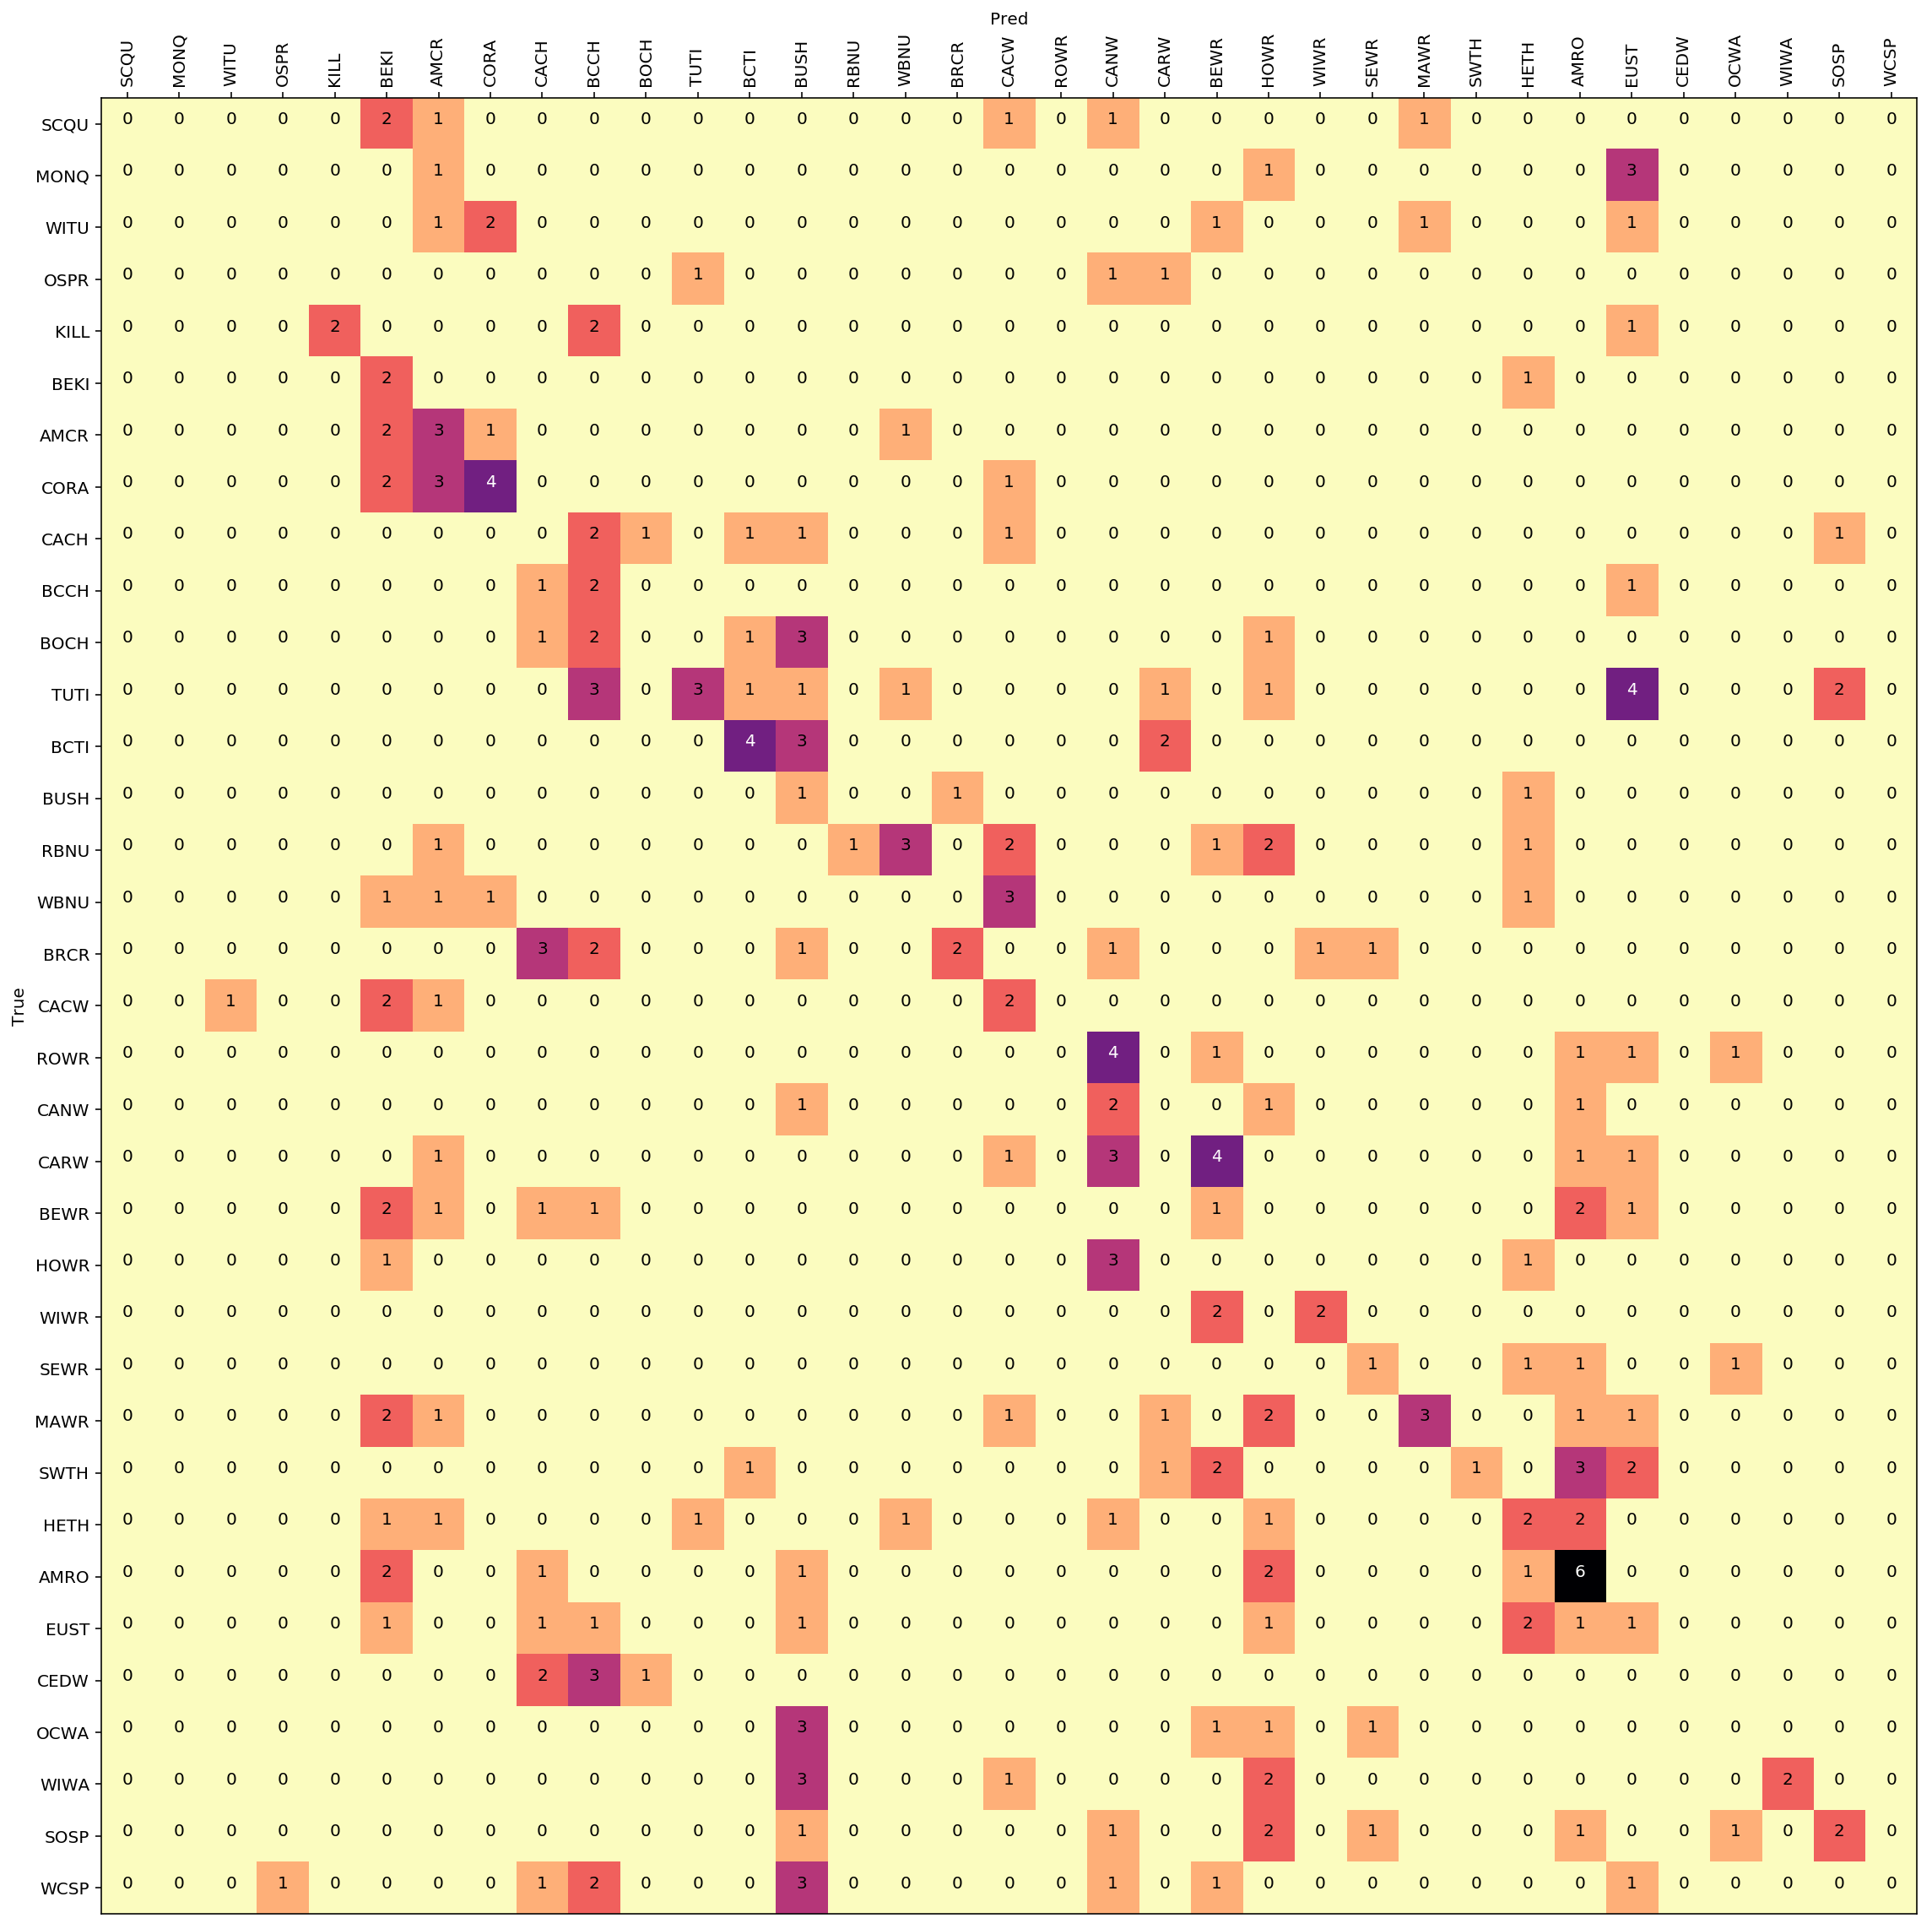

CPU times: user 5.38 s, sys: 514 ms, total: 5.9 s
Wall time: 5.35 s


In [ ]:
%%time
with with_figsize('full'):
    search.plot_confusion_matrix(recs_test)